In [16]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
pharma_data = pd.read_csv('Pharmaceuticals.csv')

# Display the first few rows of the dataset to understand its structure
print(pharma_data.head())

  Symbol                 Name  Market_Cap  Beta  PE_Ratio   ROE   ROA  \
0    ABT  Abbott Laboratories       68.44  0.32      24.7  26.4  11.8   
1    AGN       Allergan, Inc.        7.58  0.41      82.5  12.9   5.5   
2    AHM         Amersham plc        6.30  0.46      20.7  14.9   7.8   
3    AZN      AstraZeneca PLC       67.63  0.52      21.5  27.4  15.4   
4    AVE              Aventis       47.16  0.32      20.1  21.8   7.5   

   Asset_Turnover  Leverage  Rev_Growth  Net_Profit_Margin  \
0             0.7      0.42        7.54               16.1   
1             0.9      0.60        9.16                5.5   
2             0.9      0.27        7.05               11.2   
3             0.9      0.00       15.00               18.0   
4             0.6      0.34       26.81               12.9   

  Median_Recommendation Location Exchange  
0          Moderate Buy       US     NYSE  
1          Moderate Buy   CANADA     NYSE  
2            Strong Buy       UK     NYSE  
3         Mo

In [17]:
# Select numerical variables (columns 3 to 11)
numerical_data = pharma_data.iloc[:, 2:11]

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Calculate pairwise Euclidean distances
distance_matrix = squareform(pdist(normalized_data, metric='euclidean'))

# Convert to DataFrame for easy readability
distance_matrix_df = pd.DataFrame(distance_matrix, 
                                   index=pharma_data['Name'], 
                                   columns=pharma_data['Name'])

# Find the most similar and dissimilar pairs
most_similar = np.unravel_index(np.argmin(np.triu(distance_matrix, 1)), distance_matrix.shape)
most_dissimilar = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)

most_similar_pair = (distance_matrix_df.index[most_similar[0]], 
                     distance_matrix_df.columns[most_similar[1]])
most_dissimilar_pair = (distance_matrix_df.index[most_dissimilar[0]], 
                        distance_matrix_df.columns[most_dissimilar[1]])

print("Most Similar Pair:", most_similar_pair)
print("Most Dissimilar Pair:", most_dissimilar_pair)


Most Similar Pair: ('Abbott Laboratories', 'Abbott Laboratories')
Most Dissimilar Pair: ('Bayer AG', 'GlaxoSmithKline plc')


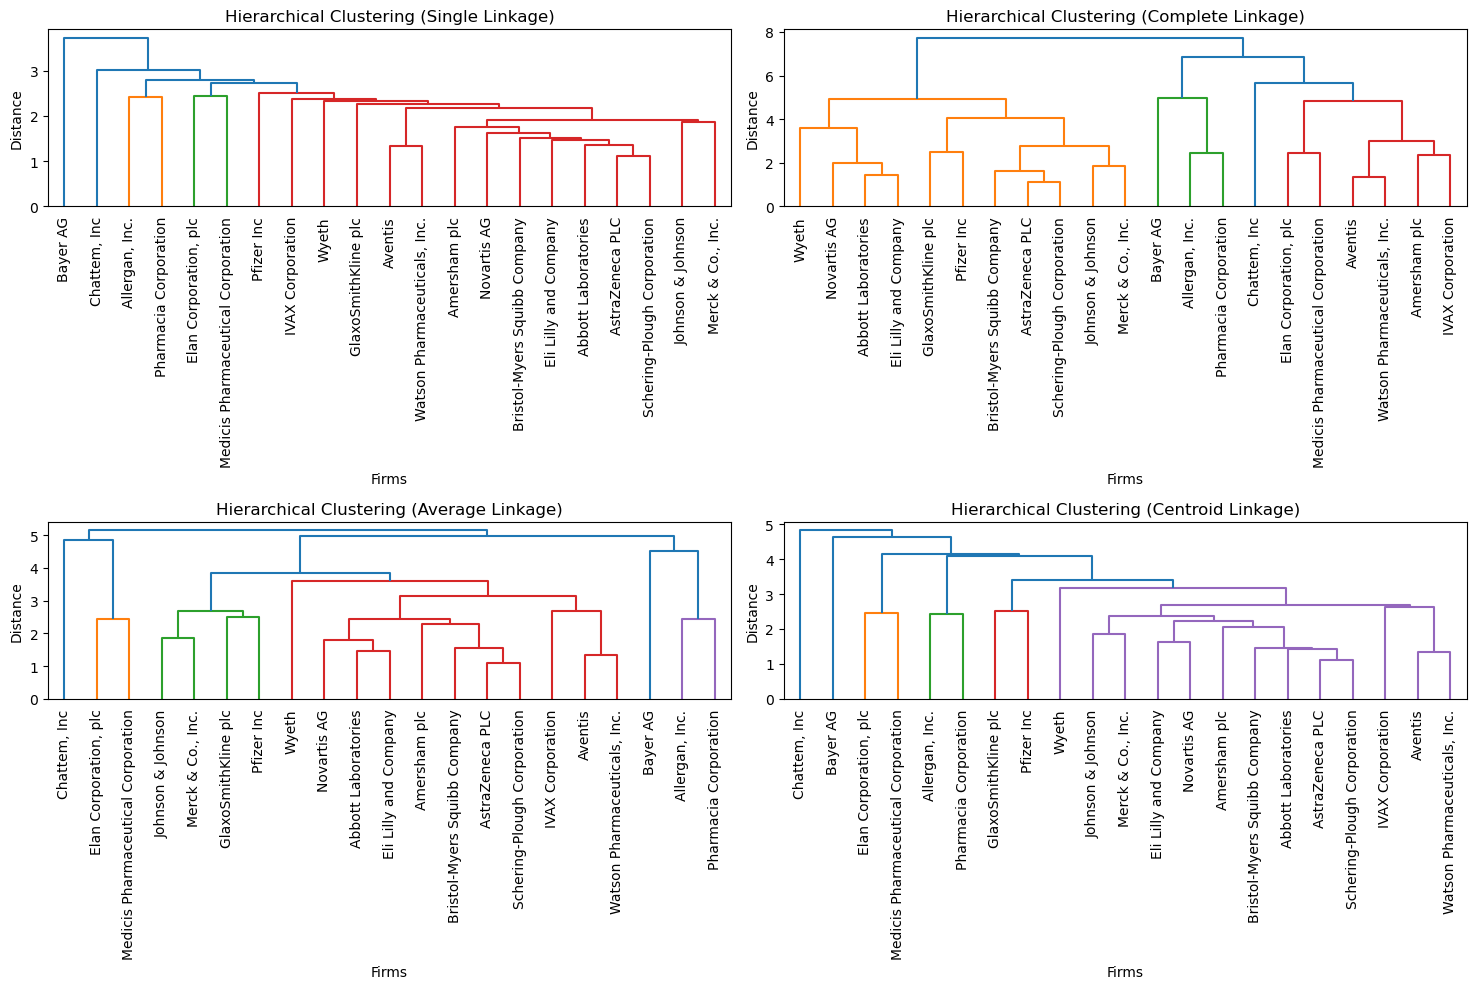

In [18]:
# Perform hierarchical clustering with various linkage methods
linkage_methods = ['single', 'complete', 'average', 'centroid']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    linked = linkage(normalized_data, method=method)
    dendrogram(linked, ax=axes[i], labels=pharma_data['Name'].values, leaf_rotation=90)
    axes[i].set_title(f'Hierarchical Clustering ({method.capitalize()} Linkage)')
    axes[i].set_xlabel('Firms')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

In [19]:
# Single linkage clustering with a chosen cutoff distance
cutoff_distance = 1.5
linked_single = linkage(normalized_data, method='single')
clusters_single = fcluster(linked_single, cutoff_distance, criterion='distance')

# Assign firms to clusters
single_linkage_clusters = pd.DataFrame({
    'Firm': pharma_data['Name'],
    'Cluster': clusters_single
}).sort_values('Cluster')

print(single_linkage_clusters)

                                  Firm  Cluster
1                       Allergan, Inc.        1
17               Pharmacia Corporation        2
8                Elan Corporation, plc        3
13  Medicis Pharmaceutical Corporation        4
4                              Aventis        5
19        Watson Pharmaceuticals, Inc.        5
0                  Abbott Laboratories        6
3                      AstraZeneca PLC        6
18         Schering-Plough Corporation        6
9                Eli Lilly and Company        6
6         Bristol-Myers Squibb Company        7
15                         Novartis AG        8
2                         Amersham plc        9
12                   Johnson & Johnson       10
14                   Merck & Co., Inc.       11
10                 GlaxoSmithKline plc       12
20                               Wyeth       13
11                    IVAX Corporation       14
16                          Pfizer Inc       15
7                         Chattem, Inc  

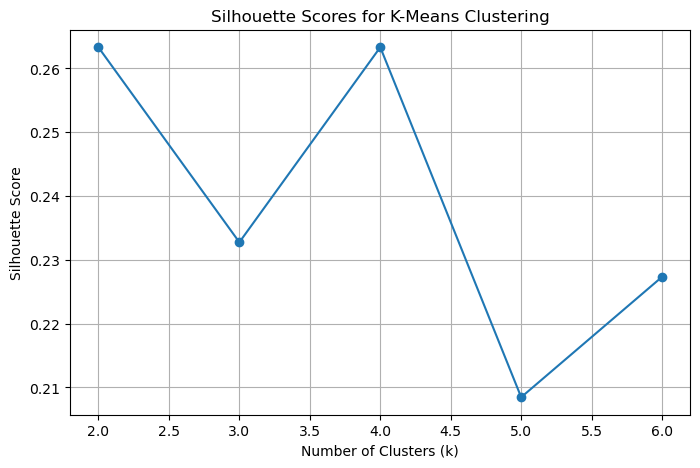

In [20]:
# Test k-values from 1 to 6
k_values = range(1, 7)
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(normalized_data)
    if k > 1:  # Silhouette score is undefined for k=1
        score = silhouette_score(normalized_data, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(None)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_values[1:], silhouette_scores[1:], marker='o')
plt.title('Silhouette Scores for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [21]:
# Perform k-means clustering for k=6
kmeans_6 = KMeans(n_clusters=6, random_state=42).fit(normalized_data)
clusters_k6 = pd.DataFrame({
    'Firm': pharma_data['Name'],
    'Cluster': kmeans_6.labels_
})

# Centroid locations for interpretation
centroids_k6 = pd.DataFrame(
    scaler.inverse_transform(kmeans_6.cluster_centers_),
    columns=numerical_data.columns
)

print("Centroids for k=6:")
print(centroids_k6)

print("Cluster Assignments for k=6:")
print(clusters_k6)

Centroids for k=6:
   Market_Cap      Beta   PE_Ratio        ROE    ROA  Asset_Turnover  \
0    0.410000  0.850000  26.000000  24.100000   4.30        0.600000   
1   11.000000  0.608000  18.120000  15.940000   6.32        0.460000   
2  139.140000  0.488000  22.080000  41.020000  17.24        0.940000   
3   31.910000  0.405000  69.500000  13.200000   5.60        0.750000   
4   54.121429  0.398571  20.114286  28.928571  12.30        0.714286   
5   16.900000  1.110000  27.900000   3.900000   1.40        0.600000   

   Leverage  Rev_Growth  Net_Profit_Margin  
0  3.510000    6.380000           7.500000  
1  0.798000   26.912000          14.720000  
2  0.176000   17.826000          19.260000  
3  0.475000   12.080000           6.400000  
4  0.424286    4.247143          19.542857  
5  0.000000   -3.170000           2.600000  
Cluster Assignments for k=6:
                                  Firm  Cluster
0                  Abbott Laboratories        4
1                       Allergan, In

In [22]:
# Merge clusters with categorical variables
clusters_with_categoricals = clusters_k6.merge(
    pharma_data[['Name', 'Median_Recommendation', 'Location', 'Exchange']],
    left_on='Firm', right_on='Name'
).drop(columns=['Name'])

# Summarize categorical patterns by cluster
categorical_patterns = clusters_with_categoricals.groupby('Cluster').agg({
    'Median_Recommendation': lambda x: x.value_counts().index[0],
    'Location': lambda x: x.value_counts().index[0],
    'Exchange': lambda x: x.value_counts().index[0]
}).reset_index()

print("Patterns in Categorical Variables by Cluster:")
print(categorical_patterns)

Patterns in Categorical Variables by Cluster:
   Cluster Median_Recommendation Location Exchange
0        0          Moderate Buy       US   NASDAQ
1        1          Moderate Buy       US     NYSE
2        2                  Hold       US     NYSE
3        3          Moderate Buy   CANADA     NYSE
4        4                  Hold       US     NYSE
5        5                  Hold  GERMANY     NYSE
